In [21]:
!nvidia-smi

Sat Jun  8 18:46:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |    793MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [22]:
!pip install imgaug

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from imgaug import parameters as iap
from imgaug import augmenters as iaa
import random
from sklearn.model_selection import train_test_split

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
X = np.load('/content/gdrive/My Drive/X.npy')
y = np.load('/content/gdrive/My Drive/y.npy')

In [6]:
print(X.shape, y.shape)

(4704, 60, 80, 3) (4704,)


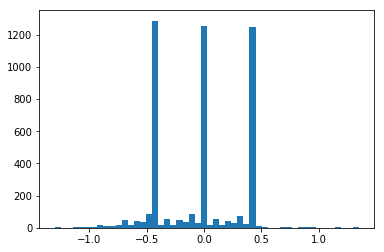

In [7]:
plt.hist(y, 50);

In [0]:
def augment(img, str_angle):
  # flip 
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    str_angle = -str_angle
  # blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  # shuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  # fog
  snow = iaa.Fog()
  img = snow.augment_image(img)
  # translate
  tx = random.randint(-20, 20)
  translater = iaa.Affine(translate_px={"x":tx}, mode="edge")
  img = translater.augment_image(img)
  str_angle += tx*0.025
  return img, str_angle

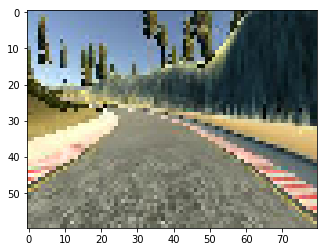

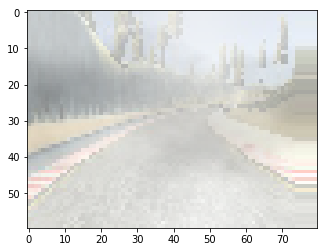

0.0 -0.125


In [27]:
test_id = 22
test_img = X[test_id]
test_sa = y[test_id]
aug_img, aug_sa = augment(test_img, test_sa)
plt.imshow(test_img)
plt.show()
plt.imshow(aug_img)
plt.show()
print(test_sa, aug_sa)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1337)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3763, 60, 80, 3) (3763,)
(941, 60, 80, 3) (941,)


In [0]:
Xy_gen = [augment(img, sa) for (img, sa) in zip(X_train, y_train)]

In [0]:
X_gen, y_gen = map(np.array, zip(*Xy_gen))

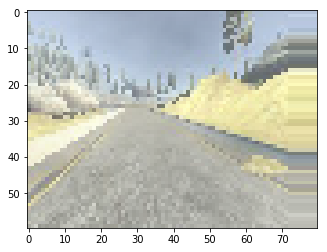

In [31]:
plt.imshow(X_gen[0])

In [15]:
!pip install livelossplot

In [0]:
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Lambda, Dropout
from keras.models import Sequential
from livelossplot import PlotLossesKeras

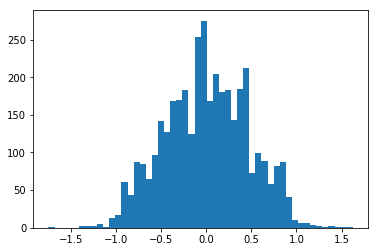

In [16]:
plt.hist(y_gen, 50);

In [45]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x - 128.0)/255.0, input_shape=input_shape, name='normalization'),
      Conv2D(64, (3,3), activation='relu'),
      Conv2D(32, (3,3), activation='relu'),
      MaxPool2D((2,2)),
      Conv2D(16, (3,3), activation='relu'),
      MaxPool2D((2,2)),
      Conv2D(8, (3,3), activation='relu'),
      MaxPool2D((2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dropout(rate=0.3),
      Dense(1),
      
  ])
  return model
  
model = myModel(X[0].shape)
model.summary()
model.compile('adam', 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Lambda)       (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 11, 16, 8)         1160      
__________

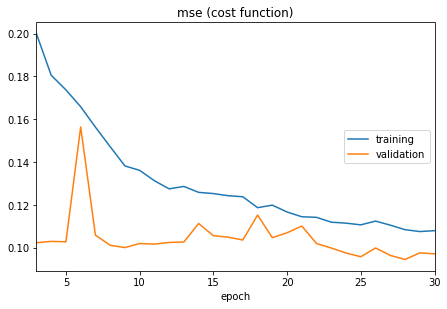

mse (cost function):
training   (min:    0.108, max:    0.220, cur:    0.108)
validation (min:    0.094, max:    0.156, cur:    0.097)


In [46]:
batch = 512
epochs = 30

model.fit(X_gen, y_gen, batch_size=batch, epochs=epochs, validation_data=(X_val, y_val), callbacks=[PlotLossesKeras()])

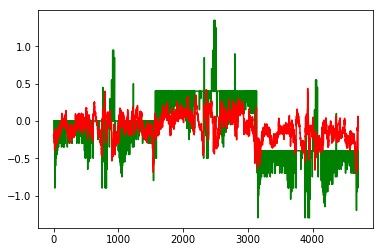

In [47]:
y_pred = model.predict(X)
plt.plot(y, 'g', y_pred, 'r')
plt.show()

In [0]:
model.save('mymodel.h5')

Autokeras

In [49]:
!pip install autokeras

     |████████████████████████████████| 71kB 2.8MB/s 
     |████████████████████████████████| 26.6MB 1.2MB/s 
     |████████████████████████████████| 582.5MB 23kB/s 
     |████████████████████████████████| 61kB 26.9MB/s 
     |████████████████████████████████| 17.3MB 46.0MB/s 
     |████████████████████████████████| 5.4MB 30.7MB/s 
     |████████████████████████████████| 25.3MB 68.7MB/s 
     |████████████████████████████████| 51kB 22.9MB/s 
     |████████████████████████████████| 3.3MB 40.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/be/a7/37/de16bfa1fbe42e7f5821c13719179ec511633fc772871e9a32
Successfully built autokeras
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existin

In [20]:
!pip uninstall torch torchvision -y
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!pip install torchvision==0.2.1

Uninstalling torch-1.0.1.post2:
  Successfully uninstalled torch-1.0.1.post2
  Using cached https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
ERROR: fastai 1.0.52 requires torchvision, which is not installed.
ERROR: autokeras 0.4.0 requires torchvision==0.2.1, which is not installed.


  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl


In [0]:
import autokeras as ak

In [0]:
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(X_gen, y_gen, time_limit=120*60)

Saving Directory: /tmp/autokeras_JGUH0B
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                                                    
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |   0.6059871941804886   |   0.2062109916174642   |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+
Epoch-9, Current Metric - 0.20

In [0]:
score = model_ak.evaluate(X_val, y_val)
score

In [0]:
y_pred = model_ak.predict(X)

In [0]:
plt.plot(y, 'g', y_pred, 'r')
plt.show()